Integrantes del equipo:
- Alonso Cañas Rico
- Hugo Jiménez García

# Parameters

In [1]:
EPOCHS = 30
LEARNING_RATE = 3e-5
BATCH_SIZE = 256
LAYERS_TO_TRAIN = 1

In [3]:
ai_generated_path = "pan24-generative-authorship-news/machines"
human_path = "pan24-generative-authorship-news/human.jsonl"

# Initial config

## Libraries

In [ ]:
import os
import json
import warnings
import logging
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, 
    brier_score_loss, fbeta_score
)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AdamW

## Device and warnings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
warnings.filterwarnings("ignore", message=".*overflowing tokens.*")
logging.disable(logging.WARNING)

# Data

## Import data

In [6]:
model, id, text = [], [], []

# Loop through every file in the directory
for filename in os.listdir(ai_generated_path):
    # Check if the file is a JSONL file
    if filename.endswith('.jsonl'):
        filepath = os.path.join(ai_generated_path, filename)
        with open(filepath, 'r', encoding='utf-8') as jsonl_file:
            for line in jsonl_file:
                # Each line is a separate JSON object
                data = json.loads(line)
                model.append(filename)
                id.append(data['id'])
                text.append(data['text'])

df_generated = pd.DataFrame({'model': model, 'id': id, 'text': text, 'ai_generated': 1})
df_generated

model  \
0                           alpaca-7b.jsonl   
1                           alpaca-7b.jsonl   
2                           alpaca-7b.jsonl   
3                           alpaca-7b.jsonl   
4                           alpaca-7b.jsonl   
...                                     ...   
14126  vicgalle-gpt2-open-instruct-v1.jsonl   
14127  vicgalle-gpt2-open-instruct-v1.jsonl   
14128  vicgalle-gpt2-open-instruct-v1.jsonl   
14129  vicgalle-gpt2-open-instruct-v1.jsonl   
14130  vicgalle-gpt2-open-instruct-v1.jsonl   

                                                      id  \
0      alpaca-7b/news-2021-01-01-2021-12-31-bideninau...   
1      alpaca-7b/news-2021-01-01-2021-12-31-bideninau...   
2      alpaca-7b/news-2021-01-01-2021-12-31-bideninau...   
3      alpaca-7b/news-2021-01-01-2021-12-31-bideninau...   
4      alpaca-7b/news-2021-01-01-2021-12-31-bideninau...   
...                                                  ...   
14126  vicgalle-gpt2-open-instruct-v1/news-2021-01-01...   
14127  vicgalle-gpt2-open-instruct-v1/news-2021-01-01...   
14128  vicgalle-gpt2-open-instruct-v1/news-2021-01-01...   
14129  vicgalle-gpt2-open-instruct-v1/news-2021-01-01...   
14130  vicgalle-gpt2-open-instruct-v1/news-2021-01-01...   

                                                    text  ai_generated  
0      Inaugural Address: President Joseph R. Biden J...             1  
1      Setting the Record Straight: Fact-Checking the...             1  
2      Joe Biden Takes the Oath of Office as 46th Pre...             1  
3      Joe Biden Takes Oath as 46th President of Unit...             1  
4      Amanda Gorman's Inspiring Poem Celebrates Hope...             1  
...                                                  ...           ...  
14126  'The Disappearance of Gabby Petito' – A Compre...             1  
14127  Utah State Police Search for Gabby Petito, Tra...             1  
14128  McKenna's Lost Friend: Debunking the Evidence ...             1  
14129  "Gunshots Found in Florida Nature Preserve: A ...             1  
14130  A Very Kind and Sweet Woman in Long Island Sho...             1  

[14131 rows x 4 columns]

In [7]:
id, text = [], []

with open(human_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        # Each line is a separate JSON object
        data = json.loads(line)
        id.append(data['id'])
        text.append(data['text'])

df_human = pd.DataFrame({'model': 'Human', 'id': id, 'text': text, 'ai_generated': 0})
df_human

model                                                 id  \
0     Human  articles-cleaned-truncated/news-2021-01-01-202...   
1     Human  articles-cleaned-truncated/news-2021-01-01-202...   
2     Human  articles-cleaned-truncated/news-2021-01-01-202...   
3     Human  articles-cleaned-truncated/news-2021-01-01-202...   
4     Human  articles-cleaned-truncated/news-2021-01-01-202...   
...     ...                                                ...   
1082  Human  articles-cleaned-truncated/news-2021-01-01-202...   
1083  Human  articles-cleaned-truncated/news-2021-01-01-202...   
1084  Human  articles-cleaned-truncated/news-2021-01-01-202...   
1085  Human  articles-cleaned-truncated/news-2021-01-01-202...   
1086  Human  articles-cleaned-truncated/news-2021-01-01-202...   

                                                   text  ai_generated  
0     Inaugural Address by President Joseph R. Biden...             0  
1     Fact check: Biden inauguration impacted by pan...             0  
2     Highlights from Joe Biden's 2021 inauguration\...             0  
3     Biden takes the helm, appeals for unity to tak...             0  
4     'The Hill We Climb': Read Amanda Gorman's inau...             0  
...                                                 ...           ...  
1082  How amateur detectives on social media helped ...             0  
1083  Authorities searching for missing 22-year-old ...             0  
1084  Univ. of Wisconsin Oshkosh student helping Gab...             0  
1085  Did the Internet Actually Help Find Gabby Peti...             0  
1086  Gabby Petito case: Surf shop owner in her home...             0  

[1087 rows x 4 columns]

In [8]:
df = pd.concat([df_generated, df_human])[['text', 'ai_generated', 'id']]
df

text  ai_generated  \
0     Inaugural Address: President Joseph R. Biden J...             1   
1     Setting the Record Straight: Fact-Checking the...             1   
2     Joe Biden Takes the Oath of Office as 46th Pre...             1   
3     Joe Biden Takes Oath as 46th President of Unit...             1   
4     Amanda Gorman's Inspiring Poem Celebrates Hope...             1   
...                                                 ...           ...   
1082  How amateur detectives on social media helped ...             0   
1083  Authorities searching for missing 22-year-old ...             0   
1084  Univ. of Wisconsin Oshkosh student helping Gab...             0   
1085  Did the Internet Actually Help Find Gabby Peti...             0   
1086  Gabby Petito case: Surf shop owner in her home...             0   

                                                     id  
0     alpaca-7b/news-2021-01-01-2021-12-31-bideninau...  
1     alpaca-7b/news-2021-01-01-2021-12-31-bideninau...  
2     alpaca-7b/news-2021-01-01-2021-12-31-bideninau...  
3     alpaca-7b/news-2021-01-01-2021-12-31-bideninau...  
4     alpaca-7b/news-2021-01-01-2021-12-31-bideninau...  
...                                                 ...  
1082  articles-cleaned-truncated/news-2021-01-01-202...  
1083  articles-cleaned-truncated/news-2021-01-01-202...  
1084  articles-cleaned-truncated/news-2021-01-01-202...  
1085  articles-cleaned-truncated/news-2021-01-01-202...  
1086  articles-cleaned-truncated/news-2021-01-01-202...  

[15218 rows x 3 columns]

## Make combinations of text pairs

In [ ]:
test_size = 0.25
val_size = 0.125
_adjusted_val_size = val_size / (1 - test_size)

# Extraer el segundo y tercer segmento de los IDs
df['base_id'] = df['id'].apply(lambda x: '/'.join(x.split('/')[1:]))  # Coger los ids sin la parte que identifica al autor del fragmento de texto.

# Paso 1: Dividir los datos según los `base_id`
base_ids = df['base_id'].unique()
train_base_ids, test_base_ids = train_test_split(base_ids, test_size=test_size, random_state=1337)
train_base_ids, val_base_ids = train_test_split(train_base_ids, test_size=_adjusted_val_size, random_state=1337) 

# Crear DataFrames por conjunto
train = df[df['base_id'].isin(train_base_ids)]
val = df[df['base_id'].isin(val_base_ids)]
test = df[df['base_id'].isin(test_base_ids)]

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (9506, 4)
val shape: (1904, 4)
test shape: (3808, 4)


In [10]:
def create_combinations_within_id(df):
    # Lista para almacenar las combinaciones de cada `base_id`
    combinations = []
    
    # Iterar sobre cada `base_id`
    for _, group in df.groupby('base_id'):
        # Filtrar textos humanos e IA dentro del grupo
        df_human = group[group['ai_generated'] == 0][['text']].reset_index(drop=True)
        df_ia = group[group['ai_generated'] == 1][['text']].reset_index(drop=True)
        
        # Producto cartesiano dentro del `base_id`
        cartesian_df = df_human.merge(df_ia, how='cross', suffixes=('_human', '_ia'))
        cartesian_df = cartesian_df.sample(frac=1).reset_index(drop=True)
        
        # Crear las dos disposiciones
        total_combinations = len(cartesian_df)
        
        half_1 = cartesian_df.iloc[:total_combinations // 2].copy()
        half_1['comment_text_1'] = half_1['text_human']
        half_1['comment_text_2'] = half_1['text_ia']
        half_1['list'] = 0  # Etiqueta 0
        
        half_2 = cartesian_df.iloc[total_combinations // 2:].copy()
        half_2['comment_text_1'] = half_2['text_ia']
        half_2['comment_text_2'] = half_2['text_human']
        half_2['list'] = 1  # Etiqueta 1
        
        # Combinar y agregar al resultado final
        balanced_df = pd.concat([half_1, half_2], ignore_index=True)
        combinations.append(balanced_df)
    
    # Concatenar todas las combinaciones y barajar
    return pd.concat(combinations, ignore_index=True).sample(frac=1).reset_index(drop=True)


In [11]:
# Generar combinaciones restringidas por `id` para cada conjunto
train = create_combinations_within_id(train)
val = create_combinations_within_id(val)
test = create_combinations_within_id(test)

In [12]:
# Print the dimensions
print(f"train shape: {train.shape} / Text on comment_text_1 is human-generated: {train['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {train['list'].value_counts()[1]}")
print(f"val shape: {val.shape} / Text on comment_text_1 is human-generated: {val['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {val['list'].value_counts()[1]}")
print(f"test shape: {test.shape} / Text on comment_text_1 is human-generated: {test['list'].value_counts()[0]} - Text on comment_text_2 is human-generated: {test['list'].value_counts()[1]}")

train shape: (8827, 5) / Text on comment_text_1 is human-generated: 4074 - Text on comment_text_2 is human-generated: 4753
val shape: (1768, 5) / Text on comment_text_1 is human-generated: 816 - Text on comment_text_2 is human-generated: 952
test shape: (3536, 5) / Text on comment_text_1 is human-generated: 1632 - Text on comment_text_2 is human-generated: 1904


# Model

In [ ]:
# Tokenizador y modelo
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
individual_model =  BertModel.from_pretrained(model_name)

In [14]:
for param in individual_model.parameters():
    param.requires_grad = False
if LAYERS_TO_TRAIN > 0:
    for layer in individual_model.encoder.layer[-LAYERS_TO_TRAIN:]:
        for param in layer.parameters():
            param.requires_grad = True

for param in individual_model.pooler.dense.parameters():
    param.requires_grad = True

# Verify that only the classifier layer is trainable
for name, param in individual_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

embeddings.word_embeddings.weight: requires_grad = False
embeddings.position_embeddings.weight: requires_grad = False
embeddings.token_type_embeddings.weight: requires_grad = False
embeddings.LayerNorm.weight: requires_grad = False
embeddings.LayerNorm.bias: requires_grad = False
encoder.layer.0.attention.self.query.weight: requires_grad = False
encoder.layer.0.attention.self.query.bias: requires_grad = False
encoder.layer.0.attention.self.key.weight: requires_grad = False
encoder.layer.0.attention.self.key.bias: requires_grad = False
encoder.layer.0.attention.self.value.weight: requires_grad = False
encoder.layer.0.attention.self.value.bias: requires_grad = False
encoder.layer.0.attention.output.dense.weight: requires_grad = False
encoder.layer.0.attention.output.dense.bias: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.weight: requires_grad = False
encoder.layer.0.attention.output.LayerNorm.bias: requires_grad = False
encoder.layer.0.intermediate.dense.weight: requ

## Individual

In [ ]:
class IndividualTransformer(torch.nn.Module):
    def __init__(self, bert_model):
        super(IndividualTransformer, self).__init__()
        self.l1 = bert_model
        self.l2 = torch.nn.Linear(768, 768)
        self.l3 = torch.nn.Dropout(0.1)
        self.l4 = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        embed = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids).last_hidden_state[:, 0]
        embed = F.gelu(self.l3(self.l2(embed)))
        logits = self.l4(embed)
        prediction = torch.sigmoid(logits)
        return prediction


model = IndividualTransformer(individual_model)
model.to(device)

IndividualTransformer(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

# Training

## Loss and optimizer

In [ ]:
loss_fn = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

## Data Generators

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text_1 = dataframe.comment_text_1
        self.comment_text_2 = dataframe.comment_text_2
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        comment_text_1 = str(self.comment_text_1[index])
        comment_text_1 = " ".join(comment_text_1.split())
        comment_text_2 = str(self.comment_text_2[index])
        comment_text_2 = " ".join(comment_text_2.split())

        inputs = self.tokenizer(comment_text_1,
                                comment_text_2,
                                max_length=self.max_len,
                                padding="max_length",
                                truncation=True,
                                return_overflowing_tokens=False,
                                return_token_type_ids=True)
        return {
            'ids': torch.tensor(inputs.input_ids, dtype=torch.long),
            'mask': torch.tensor(inputs.attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(inputs.token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
          }


In [18]:
# Instancia el dataset
train_dataset = CustomDataset(dataframe=train, tokenizer=tokenizer, max_len=512)
val_dataset = CustomDataset(dataframe=val, tokenizer=tokenizer, max_len=512)
test_dataset = CustomDataset(dataframe=test, tokenizer=tokenizer, max_len=512)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training and metrics methods

In [20]:
def c_at_1(targets, preds):
    """
    Calculates the C@1 metric:
    - Non-answers (predictions marked as -1) are given a score of 0.5.
    - Remaining cases are scored based on accuracy.
    
    Parameters:
        targets (np.array): Ground truth labels.
        preds (np.array): Predictions, where -1 indicates a non-answer.
    
    Returns:
        float: C@1 metric.
    """
    correct = (targets == preds)  # Boolean array for correct predictions
    unanswered = preds == -1     # Boolean array for non-answers
    
    num_correct = correct.sum()
    num_total = len(targets)
    num_unanswered = unanswered.sum()
    
    return (num_correct + num_unanswered * 0.5) / num_total

In [ ]:
# Función de entrenamiento
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Use tqdm to wrap the loader for a progress bar
    for batch in tqdm(loader, desc="Training", leave=True):
        labels = batch['labels'].unsqueeze(1).to(device).float()
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Función de evaluación
def evaluate(model, loader, device):
    model.eval()
    preds, targets, probabilities = [], [], []

    with torch.no_grad():
        for batch in loader:
            labels = batch['labels'].unsqueeze(1).float()
            batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**batch)
            probabilities.extend(outputs.cpu().numpy())
            preds.extend(torch.round(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    probabilities = np.array(probabilities).flatten()
    
    # Calculate metrics
    roc_auc = roc_auc_score(targets, probabilities)
    brier = brier_score_loss(targets, probabilities)
    f1 = f1_score(targets, preds)
    f05u = fbeta_score(targets, preds, beta=0.5)
    c1 = c_at_1(targets, preds)
    mean = np.mean([roc_auc, 1-brier, c1, f1, f05u])
    
    return {
        "accuracy": accuracy_score(targets, preds),
        "roc-auc": roc_auc,
        "brier": brier,
        "c@1": c1,
        "f1": f1,
        "f05u": f05u,
        "mean": mean,
    }


## Training

In [ ]:
history = {
    "train_loss": [],
    "train_metrics": [],
    "val_metrics": []
}

save_path = f"models/models_individual_concatenate_embeddings/bert-base/fine_tuned_model_{EPOCHS}_epochs_{LEARNING_RATE}_lr_{LAYERS_TO_TRAIN}_layers_{BATCH_SIZE}_batch_size"

for epoch in range(EPOCHS):
    print(f"Starting Epoch {epoch + 1}/{EPOCHS}")
    print("* Training")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)

    print("* Saving model")
    _epoch_save_path = f"{save_path}_checkpoint_{epoch + 1}.pth"
    torch.save(model, _epoch_save_path)

    print("* Calculating metrics for training")
    train_metrics  = evaluate(model, train_loader, device)
    print("* Calculating metrics for validation")
    val_metrics  = evaluate(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["train_metrics"].append(train_metrics)
    history["val_metrics"].append(val_metrics)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print("Train Metrics:")
    for metric_name, value in train_metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("Validation Metrics:")
    for metric_name, value in val_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

Starting Epoch 1/30
* Training


Training: 100%|██████████| 35/35 [01:59<00:00,  3.42s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 1/30
Train Loss: 0.6848
Train Metrics:
  accuracy: 0.5408
  roc-auc: 0.7642
  brier: 0.2423
  c@1: 0.5408
  f1: 0.7006
  f05u: 0.5944
  mean: 0.6716
Validation Metrics:
  accuracy: 0.5419
  roc-auc: 0.7908
  brier: 0.2415
  c@1: 0.5419
  f1: 0.7013
  f05u: 0.5950
  mean: 0.6775
Starting Epoch 2/30
* Training


Training: 100%|██████████| 35/35 [01:58<00:00,  3.38s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 2/30
Train Loss: 0.6578
Train Metrics:
  accuracy: 0.8200
  roc-auc: 0.9128
  brier: 0.2057
  c@1: 0.8200
  f1: 0.8426
  f05u: 0.8140
  mean: 0.8367
Validation Metrics:
  accuracy: 0.8467
  roc-auc: 0.9328
  brier: 0.2023
  c@1: 0.8467
  f1: 0.8648
  f05u: 0.8395
  mean: 0.8563
Starting Epoch 3/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 3/30
Train Loss: 0.4271
Train Metrics:
  accuracy: 0.9494
  roc-auc: 0.9890
  brier: 0.0424
  c@1: 0.9494
  f1: 0.9519
  f05u: 0.9649
  mean: 0.9626
Validation Metrics:
  accuracy: 0.9542
  roc-auc: 0.9934
  brier: 0.0350
  c@1: 0.9542
  f1: 0.9564
  f05u: 0.9711
  mean: 0.9680
Starting Epoch 4/30
* Training


Training: 100%|██████████| 35/35 [02:00<00:00,  3.43s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 4/30
Train Loss: 0.1206
Train Metrics:
  accuracy: 0.9805
  roc-auc: 0.9978
  brier: 0.0162
  c@1: 0.9805
  f1: 0.9820
  f05u: 0.9802
  mean: 0.9849
Validation Metrics:
  accuracy: 0.9802
  roc-auc: 0.9987
  brier: 0.0143
  c@1: 0.9802
  f1: 0.9816
  f05u: 0.9819
  mean: 0.9856
Starting Epoch 5/30
* Training


Training: 100%|██████████| 35/35 [01:57<00:00,  3.36s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 5/30
Train Loss: 0.0669
Train Metrics:
  accuracy: 0.9879
  roc-auc: 0.9992
  brier: 0.0098
  c@1: 0.9879
  f1: 0.9888
  f05u: 0.9870
  mean: 0.9906
Validation Metrics:
  accuracy: 0.9864
  roc-auc: 0.9993
  brier: 0.0100
  c@1: 0.9864
  f1: 0.9874
  f05u: 0.9868
  mean: 0.9900
Starting Epoch 6/30
* Training


Training: 100%|██████████| 35/35 [01:58<00:00,  3.38s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 6/30
Train Loss: 0.0480
Train Metrics:
  accuracy: 0.9922
  roc-auc: 0.9997
  brier: 0.0062
  c@1: 0.9922
  f1: 0.9927
  f05u: 0.9938
  mean: 0.9945
Validation Metrics:
  accuracy: 0.9864
  roc-auc: 0.9994
  brier: 0.0093
  c@1: 0.9864
  f1: 0.9874
  f05u: 0.9892
  mean: 0.9906
Starting Epoch 7/30
* Training


Training: 100%|██████████| 35/35 [01:58<00:00,  3.38s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 7/30
Train Loss: 0.0345
Train Metrics:
  accuracy: 0.9943
  roc-auc: 0.9999
  brier: 0.0043
  c@1: 0.9943
  f1: 0.9947
  f05u: 0.9940
  mean: 0.9957
Validation Metrics:
  accuracy: 0.9881
  roc-auc: 0.9996
  brier: 0.0083
  c@1: 0.9881
  f1: 0.9890
  f05u: 0.9868
  mean: 0.9910
Starting Epoch 8/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.31s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 8/30
Train Loss: 0.0306
Train Metrics:
  accuracy: 0.9957
  roc-auc: 0.9999
  brier: 0.0033
  c@1: 0.9957
  f1: 0.9960
  f05u: 0.9973
  mean: 0.9971
Validation Metrics:
  accuracy: 0.9887
  roc-auc: 0.9996
  brier: 0.0086
  c@1: 0.9887
  f1: 0.9894
  f05u: 0.9926
  mean: 0.9923
Starting Epoch 9/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 9/30
Train Loss: 0.0237
Train Metrics:
  accuracy: 0.9981
  roc-auc: 1.0000
  brier: 0.0018
  c@1: 0.9981
  f1: 0.9982
  f05u: 0.9976
  mean: 0.9984
Validation Metrics:
  accuracy: 0.9887
  roc-auc: 0.9996
  brier: 0.0079
  c@1: 0.9887
  f1: 0.9895
  f05u: 0.9889
  mean: 0.9918
Starting Epoch 10/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.32s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 10/30
Train Loss: 0.0187
Train Metrics:
  accuracy: 0.9981
  roc-auc: 1.0000
  brier: 0.0016
  c@1: 0.9981
  f1: 0.9982
  f05u: 0.9974
  mean: 0.9984
Validation Metrics:
  accuracy: 0.9881
  roc-auc: 0.9996
  brier: 0.0092
  c@1: 0.9881
  f1: 0.9890
  f05u: 0.9868
  mean: 0.9909
Starting Epoch 11/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 11/30
Train Loss: 0.0175
Train Metrics:
  accuracy: 0.9986
  roc-auc: 1.0000
  brier: 0.0009
  c@1: 0.9986
  f1: 0.9987
  f05u: 0.9981
  mean: 0.9989
Validation Metrics:
  accuracy: 0.9910
  roc-auc: 0.9997
  brier: 0.0065
  c@1: 0.9910
  f1: 0.9916
  f05u: 0.9904
  mean: 0.9932
Starting Epoch 12/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.31s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 12/30
Train Loss: 0.0222
Train Metrics:
  accuracy: 0.9989
  roc-auc: 1.0000
  brier: 0.0010
  c@1: 0.9989
  f1: 0.9989
  f05u: 0.9984
  mean: 0.9991
Validation Metrics:
  accuracy: 0.9904
  roc-auc: 0.9997
  brier: 0.0075
  c@1: 0.9904
  f1: 0.9911
  f05u: 0.9883
  mean: 0.9924
Starting Epoch 13/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 13/30
Train Loss: 0.0121
Train Metrics:
  accuracy: 0.9990
  roc-auc: 1.0000
  brier: 0.0007
  c@1: 0.9990
  f1: 0.9991
  f05u: 0.9985
  mean: 0.9992
Validation Metrics:
  accuracy: 0.9910
  roc-auc: 0.9997
  brier: 0.0069
  c@1: 0.9910
  f1: 0.9916
  f05u: 0.9885
  mean: 0.9928
Starting Epoch 14/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.30s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 14/30
Train Loss: 0.0100
Train Metrics:
  accuracy: 0.9992
  roc-auc: 1.0000
  brier: 0.0006
  c@1: 0.9992
  f1: 0.9993
  f05u: 0.9997
  mean: 0.9995
Validation Metrics:
  accuracy: 0.9898
  roc-auc: 0.9996
  brier: 0.0079
  c@1: 0.9898
  f1: 0.9905
  f05u: 0.9943
  mean: 0.9933
Starting Epoch 15/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.31s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 15/30
Train Loss: 0.0098
Train Metrics:
  accuracy: 0.9999
  roc-auc: 1.0000
  brier: 0.0002
  c@1: 0.9999
  f1: 0.9999
  f05u: 1.0000
  mean: 0.9999
Validation Metrics:
  accuracy: 0.9921
  roc-auc: 0.9997
  brier: 0.0060
  c@1: 0.9921
  f1: 0.9926
  f05u: 0.9939
  mean: 0.9945
Starting Epoch 16/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 16/30
Train Loss: 0.0137
Train Metrics:
  accuracy: 0.9994
  roc-auc: 1.0000
  brier: 0.0005
  c@1: 0.9994
  f1: 0.9995
  f05u: 0.9992
  mean: 0.9995
Validation Metrics:
  accuracy: 0.9893
  roc-auc: 0.9998
  brier: 0.0076
  c@1: 0.9893
  f1: 0.9901
  f05u: 0.9867
  mean: 0.9916
Starting Epoch 17/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 17/30
Train Loss: 0.0095
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0001
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9926
  roc-auc: 0.9997
  brier: 0.0062
  c@1: 0.9926
  f1: 0.9931
  f05u: 0.9960
  mean: 0.9951
Starting Epoch 18/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.30s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 18/30
Train Loss: 0.0055
Train Metrics:
  accuracy: 0.9999
  roc-auc: 1.0000
  brier: 0.0001
  c@1: 0.9999
  f1: 0.9999
  f05u: 0.9998
  mean: 0.9999
Validation Metrics:
  accuracy: 0.9932
  roc-auc: 0.9997
  brier: 0.0064
  c@1: 0.9932
  f1: 0.9937
  f05u: 0.9937
  mean: 0.9948
Starting Epoch 19/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.29s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 19/30
Train Loss: 0.0061
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0001
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9904
  roc-auc: 0.9997
  brier: 0.0073
  c@1: 0.9904
  f1: 0.9911
  f05u: 0.9902
  mean: 0.9928
Starting Epoch 20/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 20/30
Train Loss: 0.0045
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9904
  roc-auc: 0.9998
  brier: 0.0075
  c@1: 0.9904
  f1: 0.9910
  f05u: 0.9951
  mean: 0.9938
Starting Epoch 21/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.31s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 21/30
Train Loss: 0.0049
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9921
  roc-auc: 0.9998
  brier: 0.0066
  c@1: 0.9921
  f1: 0.9926
  f05u: 0.9945
  mean: 0.9945
Starting Epoch 22/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 22/30
Train Loss: 0.0055
Train Metrics:
  accuracy: 0.9999
  roc-auc: 1.0000
  brier: 0.0001
  c@1: 0.9999
  f1: 0.9999
  f05u: 0.9998
  mean: 0.9999
Validation Metrics:
  accuracy: 0.9921
  roc-auc: 0.9998
  brier: 0.0064
  c@1: 0.9921
  f1: 0.9927
  f05u: 0.9914
  mean: 0.9939
Starting Epoch 23/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.29s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 23/30
Train Loss: 0.0038
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9926
  roc-auc: 0.9997
  brier: 0.0066
  c@1: 0.9926
  f1: 0.9931
  f05u: 0.9954
  mean: 0.9949
Starting Epoch 24/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.34s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 24/30
Train Loss: 0.0036
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9921
  roc-auc: 0.9998
  brier: 0.0060
  c@1: 0.9921
  f1: 0.9926
  f05u: 0.9945
  mean: 0.9946
Starting Epoch 25/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.32s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 25/30
Train Loss: 0.0047
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9915
  roc-auc: 0.9998
  brier: 0.0060
  c@1: 0.9915
  f1: 0.9921
  f05u: 0.9906
  mean: 0.9936
Starting Epoch 26/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 26/30
Train Loss: 0.0036
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9910
  roc-auc: 0.9998
  brier: 0.0070
  c@1: 0.9910
  f1: 0.9916
  f05u: 0.9941
  mean: 0.9939
Starting Epoch 27/30
* Training


Training: 100%|██████████| 35/35 [01:55<00:00,  3.31s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 27/30
Train Loss: 0.0033
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9938
  roc-auc: 0.9998
  brier: 0.0054
  c@1: 0.9938
  f1: 0.9942
  f05u: 0.9939
  mean: 0.9953
Starting Epoch 28/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.32s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 28/30
Train Loss: 0.0036
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9915
  roc-auc: 0.9998
  brier: 0.0074
  c@1: 0.9915
  f1: 0.9921
  f05u: 0.9955
  mean: 0.9943
Starting Epoch 29/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.33s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 29/30
Train Loss: 0.0032
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9915
  roc-auc: 0.9998
  brier: 0.0058
  c@1: 0.9915
  f1: 0.9921
  f05u: 0.9943
  mean: 0.9944
Starting Epoch 30/30
* Training


Training: 100%|██████████| 35/35 [01:56<00:00,  3.32s/it]


* Saving model
* Calculating metrics for training
* Calculating metrics for validation
Epoch 30/30
Train Loss: 0.0040
Train Metrics:
  accuracy: 1.0000
  roc-auc: 1.0000
  brier: 0.0000
  c@1: 1.0000
  f1: 1.0000
  f05u: 1.0000
  mean: 1.0000
Validation Metrics:
  accuracy: 0.9932
  roc-auc: 0.9998
  brier: 0.0053
  c@1: 0.9932
  f1: 0.9937
  f05u: 0.9943
  mean: 0.9951


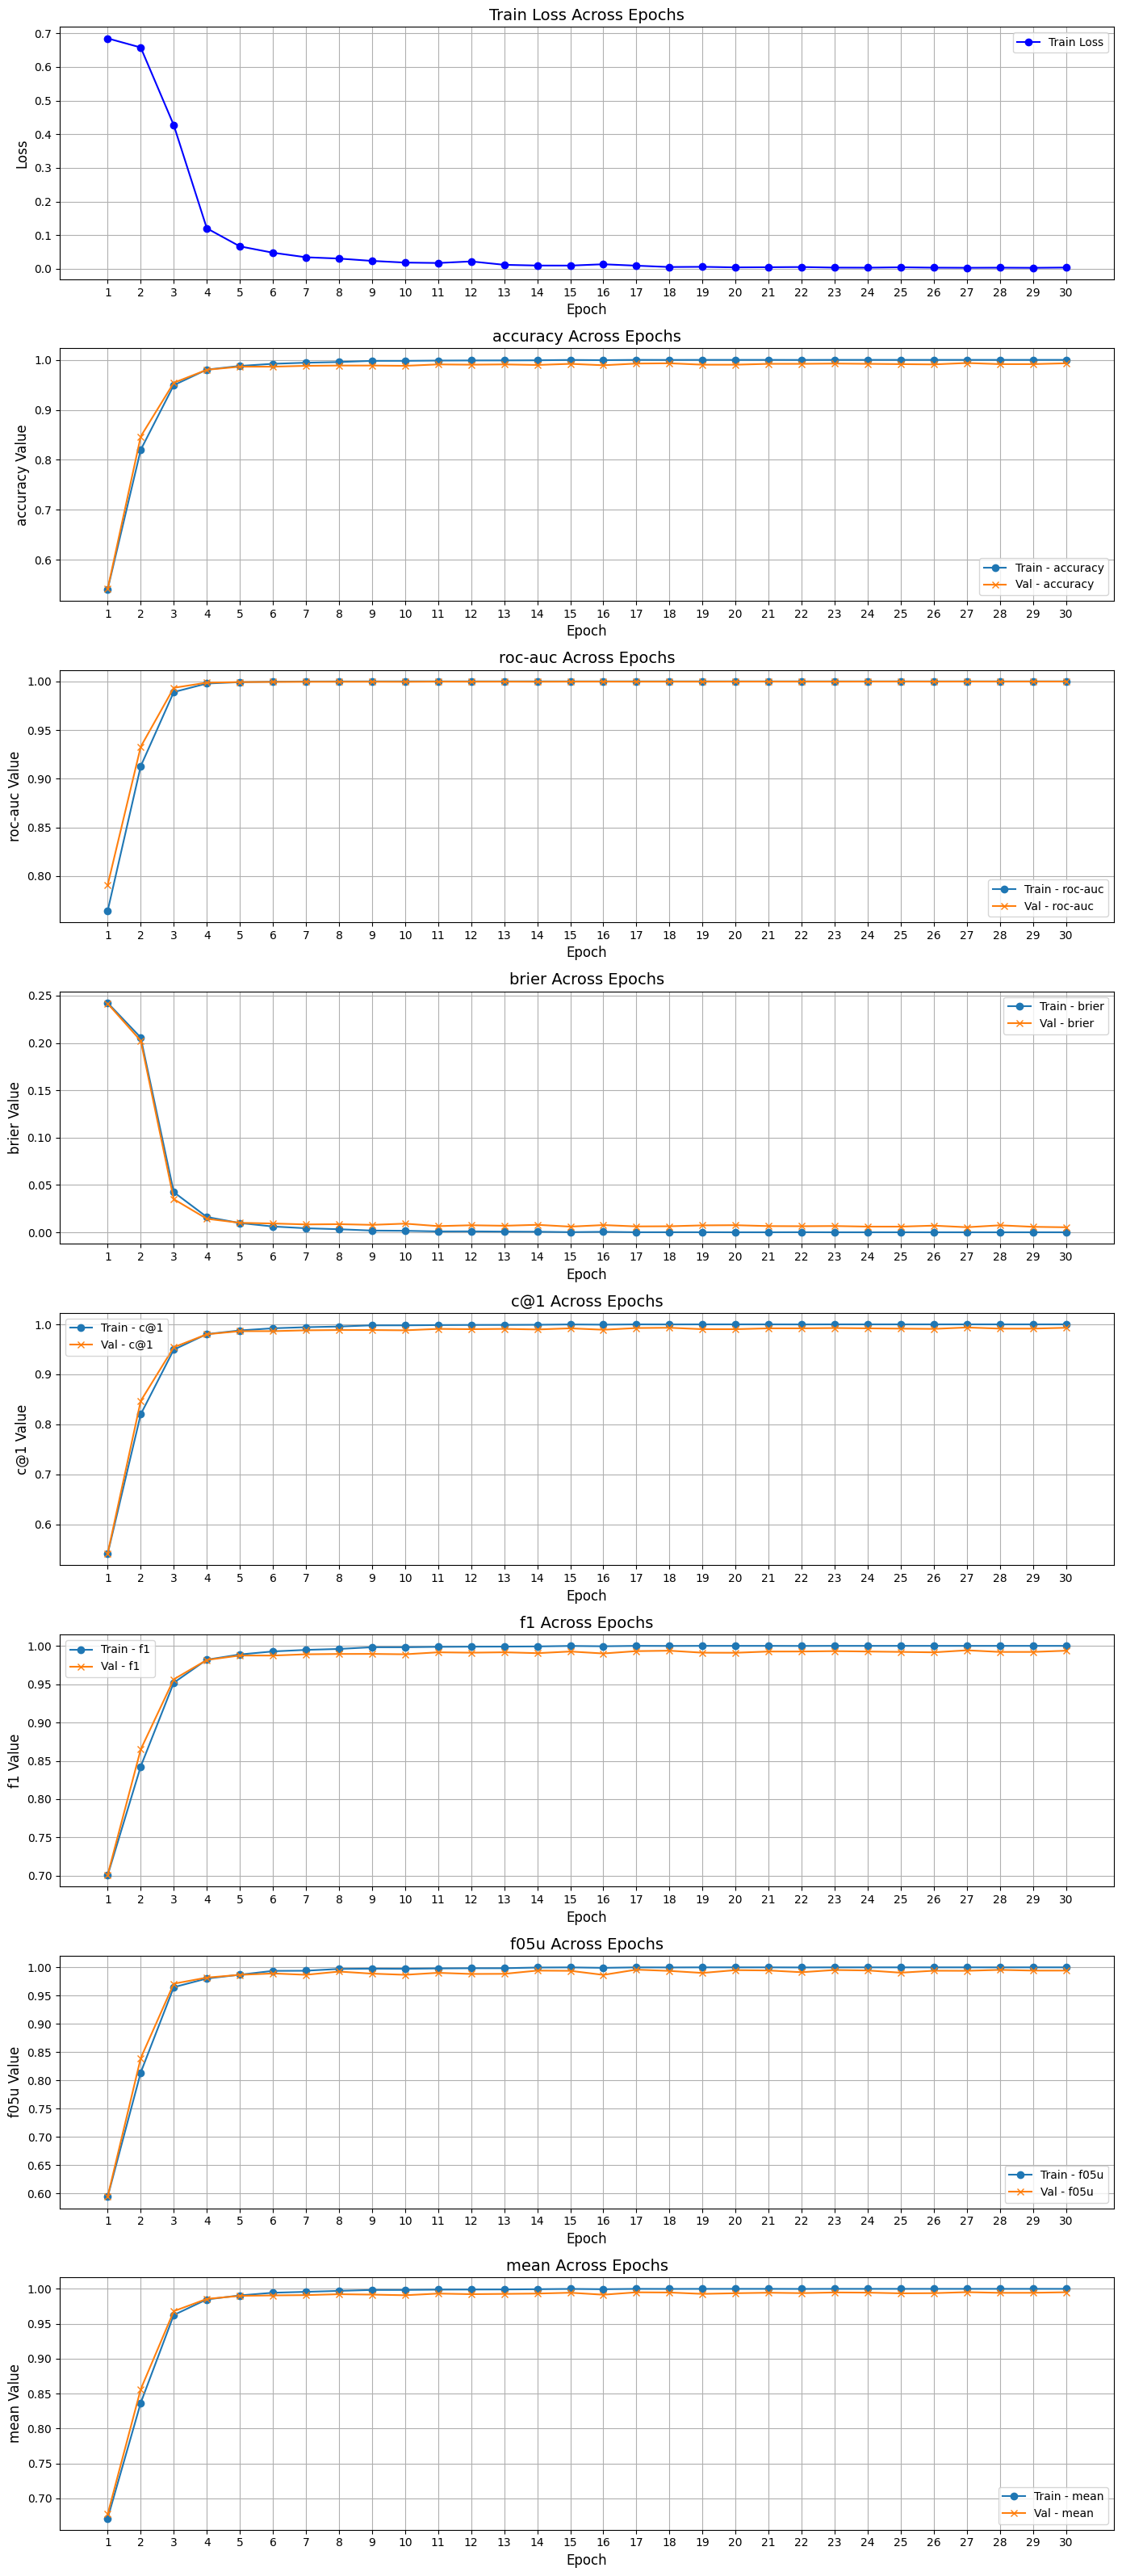

In [ ]:
metric_names = history["val_metrics"][0].keys()
epochs = list(range(1, len(history["val_metrics"]) + 1))

train_values = {name: [epoch.get(name, None) for epoch in history["train_metrics"]] for name in metric_names}
val_values = {name: [epoch.get(name, None) for epoch in history["val_metrics"]] for name in metric_names}

num_subplots = len(metric_names) + 1  # Number of metrics + train loss
plt.figure(figsize=(14, 4 * num_subplots))  # Increase height proportional to the number of plots

# Plot train loss
plt.subplot(num_subplots, 1, 1)

plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o", color="blue")
plt.title("Train Loss Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Plotting each metric in a separate graph
for idx, metric in enumerate(metric_names):
    plt.subplot(len(metric_names) + 1, 1, idx + 2)  # Adjust index for additional loss plot
    plt.plot(epochs, train_values[metric], label=f'Train - {metric}', marker='o')
    plt.plot(epochs, val_values[metric], label=f'Val - {metric}', marker='x')
    plt.title(f"{metric} Across Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{metric} Value", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Final evaluation (Classification)

In [ ]:
model = torch.load('models/models_individual_concatenate_embeddings/bert-base/fine_tuned_model_30_epochs_3e-05_lr_1_layers_256_batch_size_checkpoint_18.pth')

In [34]:
# Evaluación final en el conjunto de prueba
train_accuracy = evaluate(model, train_loader, device)
print(f"Train Metrics: {train_accuracy}")
val_accuracy = evaluate(model, val_loader, device)
print(f"Val Metrics: {val_accuracy}")
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Metrics: {test_accuracy}")

Train Metrics: {'accuracy': 0.9998867112269174, 'roc-auc': 1.0, 'brier': 0.00010470834470326219, 'c@1': 0.9998867112269174, 'f1': 0.999894814347323, 'f05u': 0.9998317135765071, 'mean': 0.999901706161209}
Val Metrics: {'accuracy': 0.9932126696832579, 'roc-auc': 0.9997116493656286, 'brier': 0.006375156894315145, 'c@1': 0.9932126696832579, 'f1': 0.9936974789915967, 'f05u': 0.9936974789915967, 'mean': 0.994788824027553}
Test Metrics: {'accuracy': 0.9892533936651584, 'roc-auc': 0.9993335109779207, 'brier': 0.00898538046740957, 'c@1': 0.9892533936651584, 'f1': 0.9900471451021479, 'f05u': 0.9884937238493724, 'mean': 0.991628478625438}
